In [1]:
from oracle import simple_oracle
import time

In [2]:
# helper functions
def floor(a, b):
    return a // b

def ceil(a, b):
    return a // b + (a % b > 0)

def bytes_to_int(bytes):
    return int.from_bytes(bytes, byteorder="big")

def int_to_bytes(n):
    l = n.bit_length()
    l = ceil(l, 8)
    bytes = n.to_bytes(l, byteorder="big")
    return bytes

In [3]:
def bleichencacher_attack(ciphertext, oracle, intervals_sizes=[]):
    """Performs Bleichencacher's Attack on ciphertext."""

    def update_interval(M, s):
        """Step 3."""
        M_new = []
        for a, b in M:
            r_min = ceil(a * s - 3 * B + 1, n)
            r_max = ceil(b * s - 2 * B, n)
            for r in range(r_min, r_max):
                lower_bound = max(a, ceil(2 * B + r * n, s))
                upper_bound = min(b, floor(3 * B - 1 + r * n, s))
                M_new.append((lower_bound, upper_bound))

        # Compute union
        M_union = []
        for start, end in sorted(M_new):
            if M_union and M_union[-1][1] >= start - 1:
                M_union[-1][1] = max(M_union[-1][1], end)
            else:
                M_union.append([start, end])
        intervals_sizes.append(sum([abs(b-a) for a,b in M_union]))
        return M_union

    n, e = oracle.get_pubkey()
    k = len(bin(n)[2:])//8
    B = 2**(8*(k-2))
    B2 = 2*B
    B3 = 3*B

    c = bytes_to_int(ciphertext)

    # Step 1.
    print("Step 1. Find s_0...")
    s_0 = 1
    if(not oracle.oracle(ciphertext)):
        while True:
            c_0 = (c * pow(s_0, e, n)) % n
            c_0 = int_to_bytes(c_0)
            if(oracle.oracle(c_0)):
                break
            s_0 += 1
    M = [(B2, B3 - 1)]
    c_0 = (c * pow(s_0, e, n)) % n

    # Step 2a.
    print("Step 2a. Start the search...")
    s = ceil(n, B3)
    while True:
        cs = (c_0 * pow(s, e, n)) % n
        cs = int_to_bytes(cs)
        if(oracle.oracle(cs)):
            break
        s += 1
    M = update_interval(M, s)
    if len(M) == 1 and M[0][0] == M[0][1]:
        return int_to_bytes(M[0][0]), M

    print("Step 2-4. Narrowing...")
    while True:
        # Step 2b.
        if len(M) > 1:
            s += 1
            while True:
                cs = (c_0 * pow(s, e, n)) % n
                cs = int_to_bytes(cs)
                if(oracle.oracle(cs)):
                    print("Found s:", s)
                    break
                s += 1

        # Step 2c.
        elif len(M) == 1:
            a, b = M[0]
            ri_min = ceil(2 * (b * s - 2 * B), n)
            ri = ri_min
            while True:
                si_min = ceil(2 * B + ri * n, b)
                si_max = ceil(3 * B + ri * n, a)

                for si in range(si_min, si_max):
                    cs = (c_0 * pow(si, e, n)) % n
                    cs = int_to_bytes(cs)
                    if(oracle.oracle(cs)):
                        s = si
                        print("Found s:", s)
                        break
                else:
                    ri += 1
                    continue
                break
        else:
            raise Exception("Empty interval")
        M = update_interval(M, s)

        # Step 4
        if len(M) == 1 and M[0][0] == M[0][1]:
            return int_to_bytes(M[0][0])

In [4]:
# main
oracle = simple_oracle(mod_size=256)
ciphertext = oracle.get_ciphertext()
intervals_sizes = []
start = time.time()
plaintext = bleichencacher_attack(ciphertext, oracle, intervals_sizes=intervals_sizes)
print("-"*20)
print(f"Ciphertext: {ciphertext}")
print(f"Elapsed time: {time.time() - start}")
print(f"# of oracle access: {oracle.queries}")
print(f"Message: {plaintext}")

Step 1. Find s_0...
Step 2a. Start the search...
Step 2-4. Narrowing...
Found s: 213305
Found s: 583032
Found s: 2161482
Found s: 4934435
Found s: 10096393
Found s: 20534072
Found s: 41594293
Found s: 83444550
Found s: 166945980
Found s: 334105263
Found s: 668253186
Found s: 1336534812
Found s: 2673382469
Found s: 5347547052
Found s: 10695236306
Found s: 21390572153
Found s: 42782850738
Found s: 85565815237
Found s: 171131815337
Found s: 342264697193
Found s: 684529437046
Found s: 1369058902532
Found s: 2738118857363
Found s: 5476238283536
Found s: 10952476723494
Found s: 21904953873595
Found s: 43809909453622
Found s: 87619819220089
Found s: 175239638610820
Found s: 350479277577146
Found s: 700958555836864
Found s: 1401917112185657
Found s: 2803834224726820
Found s: 5607668449880247
Found s: 11215336900485727
Found s: 22430673801184757
Found s: 44861347603691998
Found s: 89722695207782163
Found s: 179445390415763409
Found s: 358890780832109848
Found s: 717781561664432999
Found s: 1435

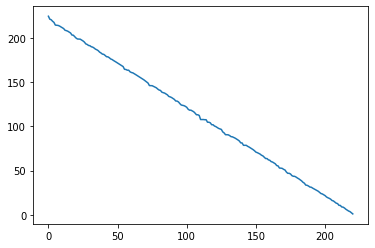

In [5]:
import matplotlib.pyplot as plt
from math import log2

plt.plot([log2(i) for i in intervals_sizes if i != 0])
plt.show()